In [1]:
import numpy as np

from matplotlib import pyplot as plt

import ot

from typing import Dict
from numpy import typing as npt
from sys import stderr

In [2]:
def read_chains(filename: str) -> Dict[str, npt.NDArray]:
    try:
        with open(filename, "r") as f:
            chains = dict()
            for line in f.readlines():
                name, *data = line.split()
                chains[name] = np.array(list(map(float, data)))
            return chains
    except IOError as e:
        print(f"{e}", file=stderr)
        return dict()

In [3]:
def generate_data(chain, n, x_low, x_high):
    assert chain['theta0'].shape == chain['theta1'].shape
    assert chain['theta0'].shape == chain['log_posterior'].shape
    idxs = np.random.randint(0, chain['theta0'].shape[0], n)
    xs = np.random.uniform(x_low, x_high, n)
    ys = np.array([chain['theta0'][idx] * x + chain['theta1'][idx] for idx, x in zip(idxs, xs)])

    return xs, ys

In [4]:
def get_no_hc_data(ns, orig_data, n_gen_iter, n_sws_proj=1000):
    x_low  = np.min(orig_data[:, 0])
    x_high = np.max(orig_data[:, 0])
    num_samples = orig_data.shape[0]

    def gen_and_calc_dist(chains):
        synth_x, synth_y = generate_data(chain=chains, n=num_samples, x_low=x_low, x_high=x_high)
        synth_data = np.array([synth_x, synth_y]).T
        return ot.sliced_wasserstein_distance(X_s=synth_data, X_t=orig_data, n_projections=n_sws_proj)

    dists = list()
    for n in ns:
        filename = f"../simpson_convergence/no_hc_{n}.txt"
        chains = read_chains(filename=filename)

        sws_dist = 0
        for _ in range(n_gen_iter):
            sws_dist += gen_and_calc_dist(chains)
        sws_dist /= n_gen_iter

        dists.append(sws_dist)

    return np.array(dists)

In [5]:
def get_with_hc_data(ns, orig_data, num_hypercubes, n_gen_iter, n_sws_proj=1000):
    x_low  = np.min(orig_data[:, 0])
    x_high = np.max(orig_data[:, 0])
    num_samples = orig_data.shape[0]

    def gen_and_calc_dist(chains):
        synth_x, synth_y = generate_data(chain=chains, n=num_samples, x_low=x_low, x_high=x_high)
        synth_data = np.array([synth_x, synth_y]).T
        return ot.sliced_wasserstein_distance(X_s=synth_data, X_t=orig_data, n_projections=n_sws_proj)

    dists = list()
    for n in ns:
        chains = [read_chains(f"../simpson_convergence/with_hc_{n}_{i}.txt") for i in range(num_hypercubes)]
        chains_hc_comb = {key: np.concatenate([chain[key] for chain in chains]) for key in chains[0]}

        sws_dist = 0
        for _ in range(n_gen_iter):
            sws_dist += gen_and_calc_dist(chains_hc_comb)
        sws_dist /= n_gen_iter

        dists.append(sws_dist)

    return np.array(dists)

In [6]:
with open("../../benchmarks/data/simpson/test_data.txt", "r") as f:
    x_data = np.array(list(map(float, f.readline().split())))
    y_data = np.array(list(map(float, f.readline().split())))

orig_data = np.array([x_data, y_data]).T

In [7]:
min  = 10   # 1_000
max  = 2000 # 200_000
step = 50   # 5_000
ns = [step * i if i > 0 else min for i in range(int(max / step + 1))]

n_gen_iter = 200
n_sws_proj = 200

In [8]:
no_hc_dists = get_no_hc_data(ns=ns, orig_data=orig_data, n_gen_iter=n_gen_iter, n_sws_proj=n_sws_proj)

In [9]:
NUM_HYPERCUBES = 6
with_hc_dists = get_with_hc_data(ns=ns, orig_data=orig_data, n_gen_iter=n_gen_iter, n_sws_proj=n_sws_proj, num_hypercubes=NUM_HYPERCUBES)

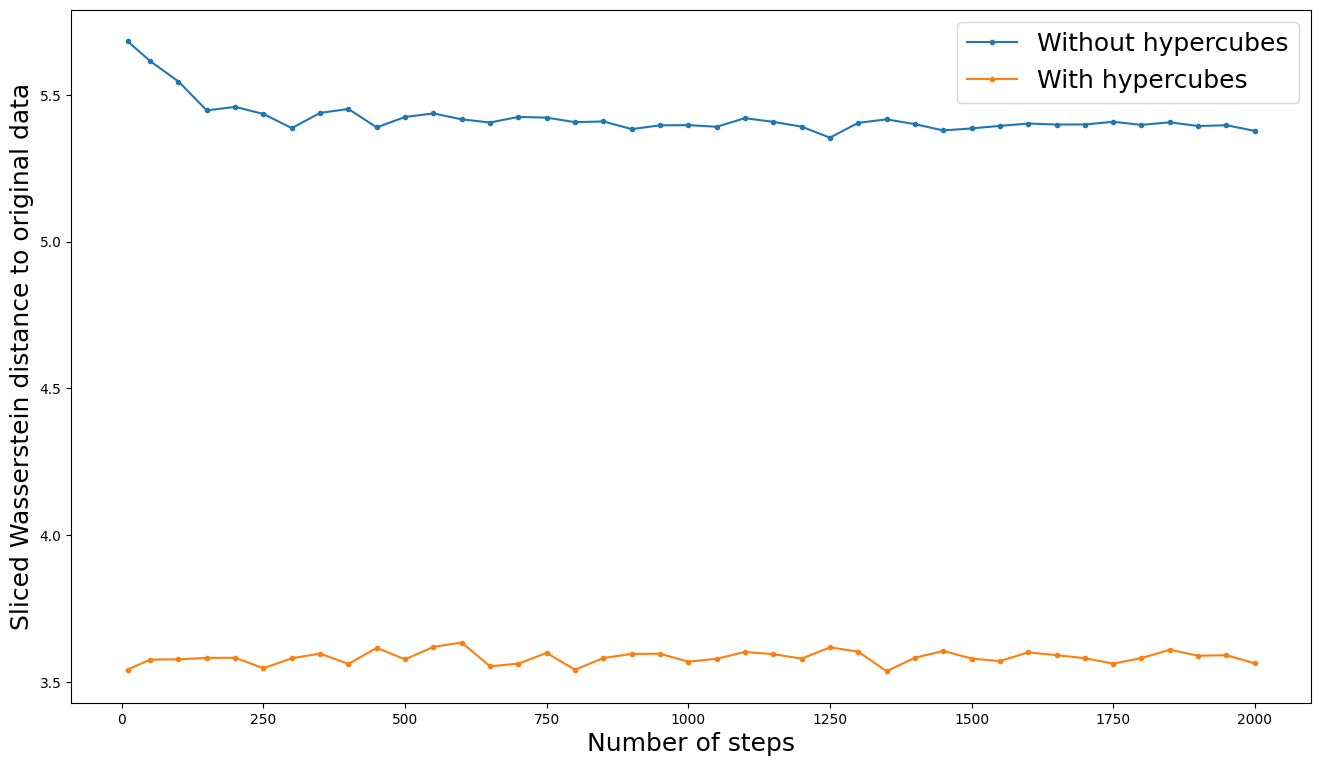

In [10]:
plt.figure(figsize=(16, 9))

plt.plot(ns, no_hc_dists, marker=".", label="Without hypercubes")
plt.plot(ns, with_hc_dists, marker=".", label="With hypercubes")

plt.xlabel("Number of steps", fontsize=18)
plt.ylabel("Sliced Wasserstein distance to original data", fontsize=18)
plt.legend(fontsize=18)

plt.show()

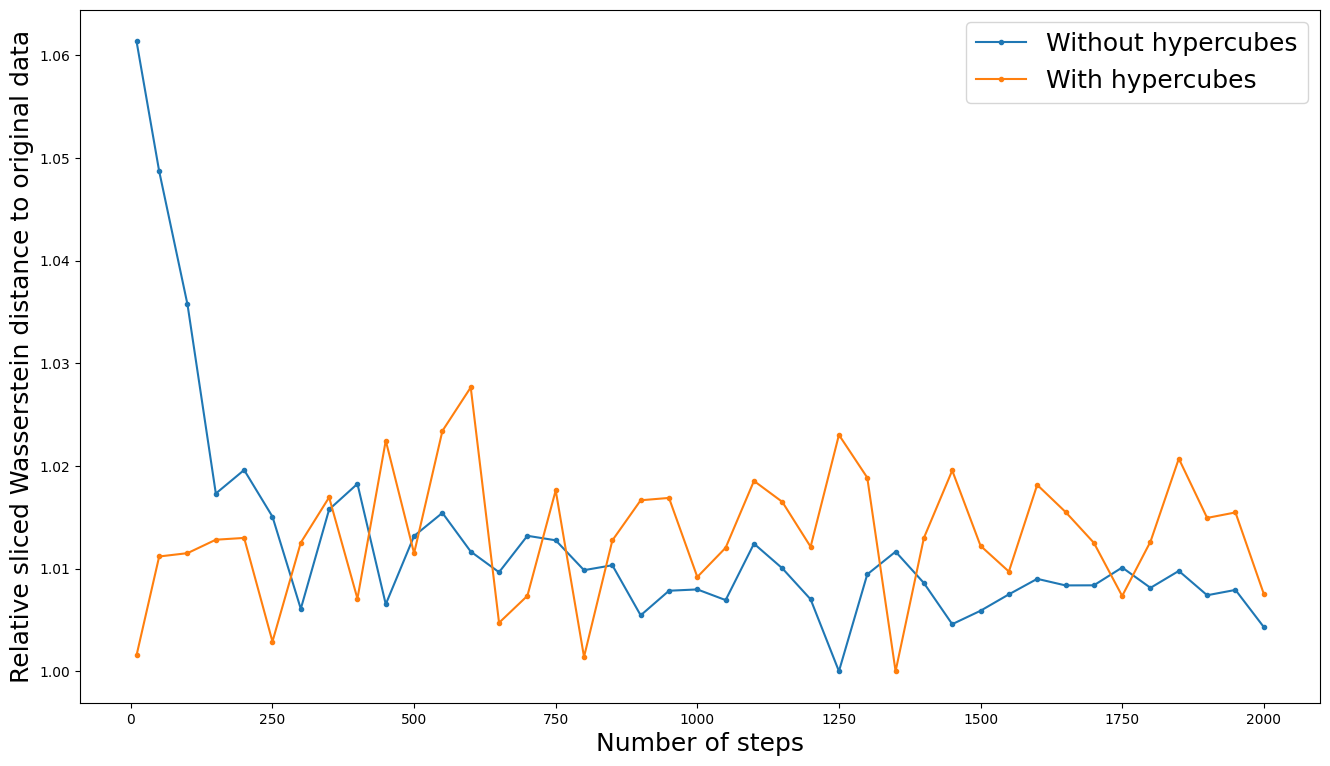

In [11]:
plt.figure(figsize=(16, 9))

plt.plot(ns, no_hc_dists / np.min(no_hc_dists), marker=".", label="Without hypercubes")
plt.plot(ns, with_hc_dists / np.min(with_hc_dists), marker=".", label="With hypercubes")

plt.xlabel("Number of steps", fontsize=18)
plt.ylabel("Relative sliced Wasserstein distance to original data", fontsize=18)
plt.legend(fontsize=18)

plt.show()